# Sberbank Data exploration and Modelling

In [1]:
path = 'C:/Users/gauth/Desktop/PGPDM/modelling_project/'

In [25]:
import pandas as pd 
import numpy as np
import math as m
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
import statsmodels.api as sm


from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import mean_absolute_error, r2_score , mean_squared_error

#to randomly split data into train and test
from sklearn.model_selection import train_test_split
%matplotlib inline
seed=45

## Importing the train and test datasets 

In [3]:
traindf = pd.read_csv(path+"train.csv")
testdf = pd.read_csv(path+"test.csv")

print(traindf.shape)
print(testdf.shape)

(30471, 292)
(7662, 291)


THe test dataset will not be used in the course of this excercise and we will only submit our scores later on into the kaggle challenge using the test. Importing it now to check scores later

### We will be trying to predict the price of houses using all the other variables in the dataset. 

# Data Exploration and Feature Creation

The dataset also has a timestamp component to it.Let's visualize the price variable.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


count         30471
mean        7123035
std         4780111
min          100000
25%         4740002
50%         6274411
75%         8300000
max       111111112
Name: price_doc, dtype: object



Price range skewness 4.474524591691862


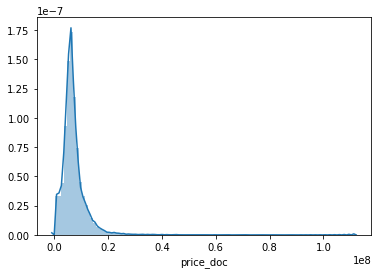

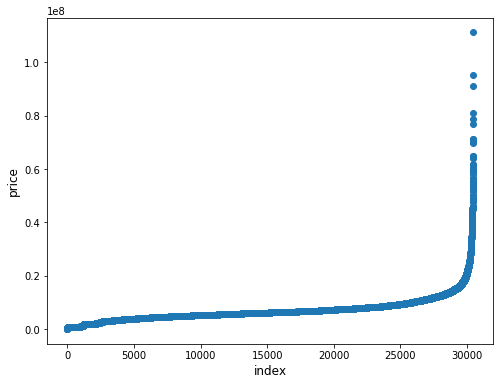

In [135]:
sns.distplot(traindf["price_doc"],bins = 100)
print(traindf["price_doc"].describe().apply(lambda x : format(x,'10.0f')))
print("\n\n\nPrice range skewness",stats.skew(traindf["price_doc"]))
plt.figure(figsize=(8,6))
plt.scatter(range(traindf.shape[0]), np.sort(traindf.price_doc.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

In [5]:
list(np.percentile(traindf["price_doc"], np.arange(0, 100, 2)))

[100000.0,
 1000000.0,
 1669748.3999999976,
 2000000.0,
 2552421.0,
 3000000.0,
 3386385.2,
 3690164.0,
 3925805.9999999995,
 4101772.3999999994,
 4319500.0,
 4500000.0,
 4650000.0,
 4806371.0,
 4990000.0,
 5100000.0,
 5226412.0,
 5360000.0,
 5500000.0,
 5600000.0,
 5700000.0,
 5818133.0,
 5938503.199999999,
 6024020.0,
 6150600.0,
 6274411.0,
 6390000.0,
 6500000.0,
 6600000.0,
 6726686.0,
 6900000.0,
 7000000.0,
 7200000.0,
 7350000.0,
 7500000.0,
 7700000.0,
 7923741.0,
 8169766.0,
 8400000.0,
 8665095.200000007,
 9000000.0,
 9391032.6,
 9900000.0,
 10414315.600000001,
 11000000.0,
 11800000.0,
 12638292.000000006,
 13800000.0,
 15500000.0,
 19189159.999999963]

We see that the price range is postively skewed with a long tail, with 98% of the prices less than 20 mil. We remove these outliers later on 

## The timestamp variable might be important in viewing the whole problem. Let's look at it

In [5]:
print("NAs in Price Doc column",traindf["price_doc"].isnull().sum(),"\n")
print("Train Data")
print("min date:",traindf["timestamp"].min())
print("max date:",traindf["timestamp"].max())
print("number of nulls",traindf["timestamp"].isna().value_counts())

print("\nTest Data")
print("min date:",testdf["timestamp"].min())
print("max date:",testdf["timestamp"].max())
print("number of nulls",testdf["timestamp"].isna().value_counts())

print("\nTime variable type before conversion: ",traindf['timestamp'].dtype)

NAs in Price Doc column 0 

Train Data
min date: 2011-08-20
max date: 2015-06-30
number of nulls False    30471
Name: timestamp, dtype: int64

Test Data
min date: 2015-07-01
max date: 2016-05-30
number of nulls False    7662
Name: timestamp, dtype: int64

Time variable type before conversion:  object


The test and the train datasets are split by time series. We have to learn from the past and predict the future

In [6]:
traindf["timestamp"]=pd.to_datetime(traindf['timestamp'])
testdf["timestamp"]=pd.to_datetime(testdf['timestamp'])
print("Time variable type : ",traindf['timestamp'].dtype)

traindf["year"] = traindf["timestamp"].dt.year
traindf["month"] = traindf["timestamp"].dt.month
testdf["year"] = testdf["timestamp"].dt.year
testdf["month"] = testdf["timestamp"].dt.month

Time variable type :  datetime64[ns]


Visualizing the timestamp variable across all dimensions like month, date and year to understand its distribution

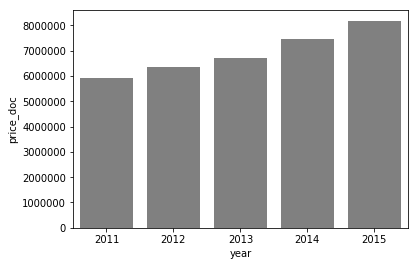

In [144]:
mean = pd.DataFrame(traindf.groupby(traindf["year"])["price_doc"].agg('mean').apply(lambda x : format(x,'10.0f')))
mean["price_doc"]=mean["price_doc"].astype(int)
mean.reset_index(level=0, inplace=True)
sns.barplot(x="year",y="price_doc",data=mean, color="grey")

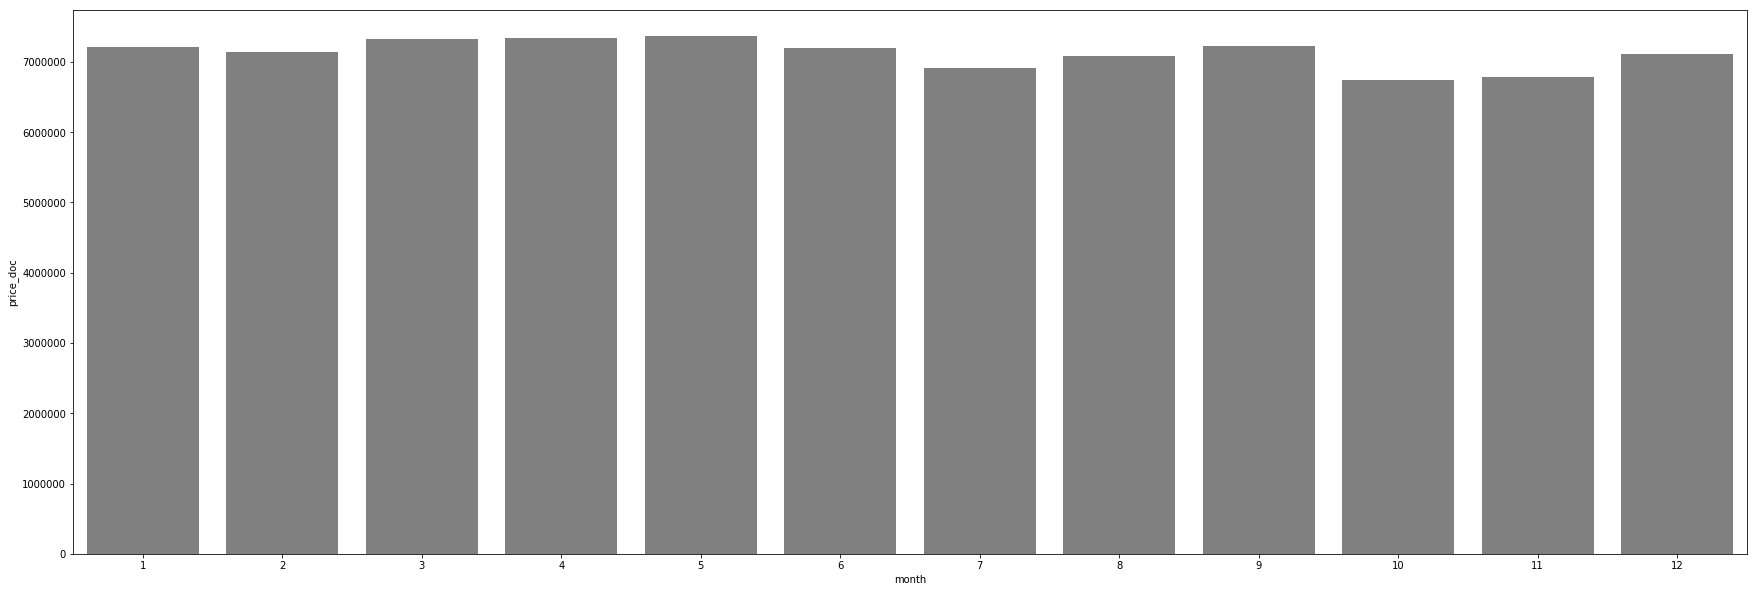

In [145]:
mean = pd.DataFrame(traindf.groupby([traindf["month"]])["price_doc"].agg('mean').apply(lambda x : format(x,'10.0f')))
mean["price_doc"]=mean["price_doc"].astype(int)
mean["month"]= mean.index
#mean.reset_index(level=0, inplace=True)
plt.figure(figsize=(30,10))
sns.barplot(x="month",y="price_doc",data=mean,color="grey")
plt.show()

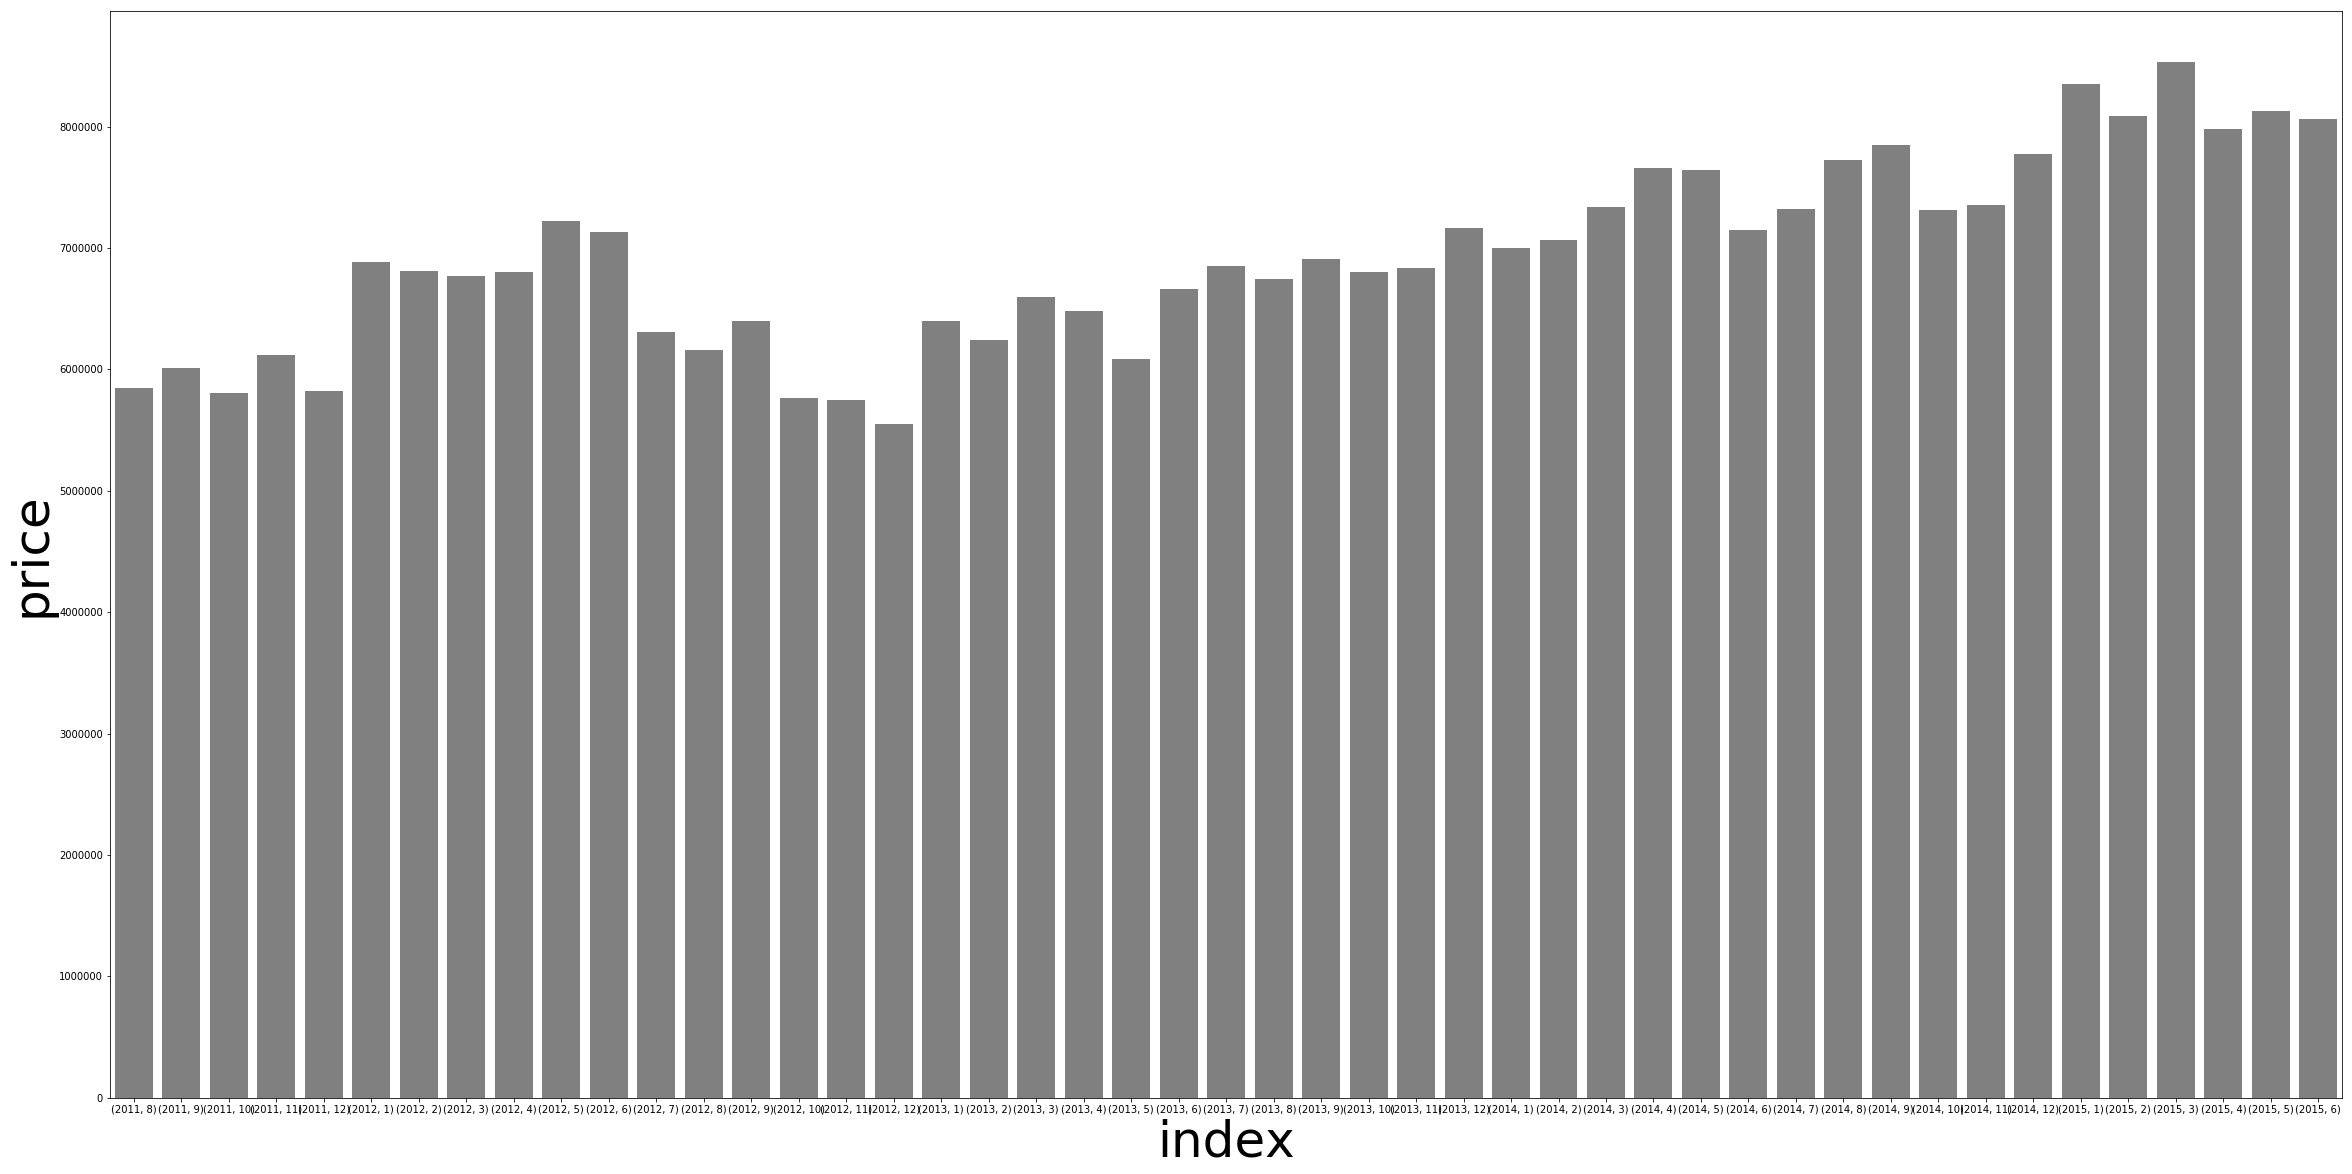

In [146]:
mean = pd.DataFrame(traindf.groupby([traindf["year"],traindf["month"]])["price_doc"].agg('mean').apply(lambda x : format(x,'10.0f')))
mean["price_doc"]=mean["price_doc"].astype(int)
mean["year"]= mean.index
#mean.reset_index(level=0, inplace=True)
plt.figure(figsize=(40,20))
sns.barplot(x="year",y="price_doc",data=mean, color="grey")
plt.xlabel('index', fontsize=50)
plt.ylabel('price', fontsize=50)
plt.show()

#plt.bar(range(mean.shape[0]),mean.price_doc.values)
#plt.xlabel('index', fontsize=50)
#plt.ylabel('price', fontsize=50)
#plt.show()

It seems like the average price is steadily increasing every year from the first chart. Specific months don't make a difference I guess, but there is a
steady growth in price after the first 18 months..So a combination of year and month might be useful inputs

In [53]:
print("Train Shape",traindf.shape)
print("Test Shape",testdf.shape)

Train Shape (30471, 294)
Test Shape (7662, 293)


Okay, the dataset has 292 variables. We might not be able to visualize all variables, but we need ways to eliminate variables that do not significantly influence price. We could start by looking at 

1) Variables with high level of null values

2) Correlation and multicolleniarity to remove redundant variables that duplicate information using VIF

3) Significance of variables in predicting the outcome ; regression table output - but this might not be useful when we implement decision tree models

4) I read about Box Cox transformation to convert non normal data in normal form at https://www.statisticshowto.datasciencecentral.com/box-cox-transformation/ . Since regression is something we will be using a lot here, let us see if it is needed.

Let's see how many of the above we can implement

## 1) Eliminate variables with high levels of null values

In [7]:
nulltable = pd.DataFrame(traindf.isnull().sum()/traindf.shape[0]).reset_index()
nulltable.columns = ['column_name', 'missing_count']
non_nullcolumns = nulltable[nulltable['missing_count']==0]
nulltable.sort_values(by="missing_count",ascending = 0).head(20)

,column_name,missing_count
24,hospital_beds_raion,0.473926
7,build_year,0.446490
10,state,0.444980
161,cafe_sum_500_max_price_avg,0.435857
160,cafe_sum_500_min_price_avg,0.435857
162,cafe_avg_price_500,0.435857
5,max_floor,0.314135
8,num_room,0.314135
9,kitch_sq,0.314135
6,material,0.314135


Highest degree of missing values is the hospital_beds_raion column with 47% . Let me remove variables with more than 10% missing values and impute -1 into the others.

In [8]:
null_columns_remove= list(nulltable[nulltable['missing_count']>.10]["column_name"])
print(traindf.shape)
print(testdf.shape)
traindf1 = traindf.drop(null_columns_remove,axis=1)
testdf1 = testdf.drop(null_columns_remove,axis=1)
print(traindf1.shape)
print(testdf1.shape)

(30471, 294)
(7662, 293)
(30471, 259)
(7662, 258)


There are now 259 variables in the data after removing variables with >10% null values

In [9]:
datatype = traindf1.dtypes.reset_index()
datatype.columns = ['column_name', 'datatype']
datatype["datatype"].value_counts()

int64             159
float64            84
object             15
datetime64[ns]      1
Name: datatype, dtype: int64

In [10]:
table = pd.merge(nulltable,datatype, how="inner",on="column_name")
table["Null"] = np.where(table["missing_count"]==0,"No","Yes")
table["type"] = np.where(table["datatype"]=="object","Category","Number")
print("There are ",non_nullcolumns.shape[0],"columns with no null values and ",
     traindf1.shape[1]-non_nullcolumns.shape[0], "columns with null values that have been filled with -1 \n")
print(pd.crosstab(table.type,table["Null"]))

There are  243 columns with no null values and  16 columns with null values that have been filled with -1 

Null       No  Yes
type              
Category   15    0
Number    228   16


### Imputing null values with -1

In [11]:
traindf1.fillna(-1,inplace=True)
testdf1.fillna(-1,inplace=True)

## Encoding Categorical Variables

Below I will be looking at all the categorical variables to see how big the dataset will become once I encode it.

In [12]:
for i in table[table["datatype"]=="object"]["column_name"] :
    print("\n",i)
    print(traindf1[i].value_counts())


 product_type
Investment       19448
OwnerOccupier    11023
Name: product_type, dtype: int64

 sub_area
Poselenie Sosenskoe               1776
Nekrasovka                        1611
Poselenie Vnukovskoe              1372
Poselenie Moskovskij               925
Poselenie Voskresenskoe            713
Mitino                             679
Tverskoe                           678
Krjukovo                           518
Mar'ino                            508
Poselenie Filimonkovskoe           496
Juzhnoe Butovo                     451
Poselenie Shherbinka               443
Solncevo                           421
Zapadnoe Degunino                  410
Poselenie Desjonovskoe             362
Otradnoe                           353
Nagatinskij Zaton                  327
Nagornoe                           305
Bogorodskoe                        305
Strogino                           301
Izmajlovo                          300
Tekstil'shhiki                     298
Ljublino                           29

We will be dropping sub_area for now. While it might be useful, it has too many categories and might require a lot of time to weed through once encoded. Other columns have relatively lower categories and will be easy to look at.

In [13]:
traindf2 = traindf1.drop("sub_area",axis=1)
testdf2 = testdf1.drop("sub_area",axis=1)
print("After removing sub_area, shape reduced from ", traindf1.shape,"to",traindf2.shape)

After removing sub_area, shape reduced from  (30471, 259) to (30471, 258)


In [14]:
traindf2 = pd.get_dummies(traindf2)
testdf2 = pd.get_dummies(testdf2)
print(traindf2.dtypes.value_counts())

int64             159
float64            84
uint8              31
datetime64[ns]      1
dtype: int64


So all categorical columns have now been converted into numerical columns and the data is more or less fit for any algorithm to parse

## 2)Checking multicolleniarity to remove redundant variables and reduce variance in prediction using VIF

How does multicollinearity affect the coeffcients in a regression problem and the final predictions?Why should you solve for multicollinearity?

So in a multiple linear regression problem, we equate y = Ax1+bx2 +c . 

y- dependant

x1 and x2 being the independant variables that are correlated

c being the intercept or constant.

When you say y = ax1 + bx2 , you mean that for a unit increase in x1, y increase by a, all else being constant. And this should be a true relationship for y and x1 irrespective of what other variables we use. But if x2 is correlated with x1, the constant a seems to be decided by the order of variables fed into the regressor and also by the number of predictors. Slight multicollinearity is tolerable as the coefficients are not strongly influnced, but high multicollinearity makes the coeffs erratic and unreliable. So the prediction might fluctuate based on the number and order of variables, which shouldn't be the case.

Hence, removing colinear variable is a need for a stable regression model.
 VIF seems to be the goto way of detecting multicollinearity. 
 VIF is calculated by 1/(1-R^2), R^2 coming out of every variable being predicted by the others using a regression model. So, R2 tells you how much of the variation in a variable is explained by the other variables, and the higher the R2, bigger the relationhip between independant variables, and ergo higher is the value of 1/(1-R2). Typical cutoff seems to be 5 for removing variables 
 on account of multicollinearity, 1-(1-.8) would give you 5, which means if a 80% of variation in a variable can be explained by other variables, it needs to be removed and not fed into a model

In [12]:
X = traindf2.drop(['id','timestamp','price_doc'], axis =1)
X = add_constant(X)
viftab = pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1543: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [29]:
vifdf=pd.DataFrame(viftab).reset_index()
vifdf.columns = ["Name","VIF"]
vifdf.sort_values("VIF",ascending=False)
#vifdf["VIF"] = vifdf["VIF"]
#vifdf["VIF"] = vifdf["VIF"].apply(lambda x : x.strip())
#vifdf1=vifdf[vifdf["VIF"] != 'inf']
#vifdf1["VIF"] =pd.to_numeric(vifdf1["VIF"])
#vifdf1.sort_values("VIF",ascending=False)

noncollinearvar=list(vifdf[vifdf["VIF"]<10]["Name"])
noncollinearvar.remove('const')
print(noncollinearvar)
vifdf.dtypes

noncollinearvar = ['full_sq', 'floor', 'green_zone_part', 'indust_part', 'school_education_centers_top_20_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'ID_metro', 'green_zone_km', 'industrial_km', 'cemetery_km', 'ID_railroad_station_walk', 'ID_railroad_station_avto', 'water_km', 'big_road1_km', 'ID_big_road1', 'ID_big_road2', 'ID_bus_terminal', 'church_synagogue_km', 'catering_km', 'green_part_500', 'prom_part_500', 'office_sqm_500', 'trc_count_500', 'trc_sqm_500', 'mosque_count_500', 'leisure_count_500', 'sport_count_500', 'market_count_500', 'trc_sqm_1000', 'mosque_count_1000', 'sport_count_1000', 'market_count_1000', 'trc_sqm_1500', 'mosque_count_1500', 'market_count_1500', 'trc_sqm_2000', 'mosque_count_2000', 'market_count_2000', 'mosque_count_3000', 'mosque_count_5000', 'year', 'month']

['full_sq', 'floor', 'green_zone_part', 'indust_part', 'school_education_centers_top_20_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'ID_metro', 'green_zone_km', 'industrial_km', 'cemetery_km', 'ID_railroad_station_walk', 'ID_railroad_station_avto', 'water_km', 'big_road1_km', 'ID_big_road1', 'ID_big_road2', 'ID_bus_terminal', 'church_synagogue_km', 'catering_km', 'green_part_500', 'prom_part_500', 'office_sqm_500', 'trc_count_500', 'trc_sqm_500', 'mosque_count_500', 'leisure_count_500', 'sport_count_500', 'market_count_500', 'trc_sqm_1000', 'mosque_count_1000', 'sport_count_1000', 'market_count_1000', 'trc_sqm_1500', 'mosque_count_1500', 'market_count_1500', 'trc_sqm_2000', 'mosque_count_2000', 'market_count_2000', 'mosque_count_3000', 'mosque_count_5000', 'year', 'month']


Name     object
VIF     float64
dtype: object

In [15]:
noncollinearvar = ['full_sq', 'floor', 'green_zone_part', 'indust_part', 'school_education_centers_top_20_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'ID_metro', 'green_zone_km', 'industrial_km', 'cemetery_km', 'ID_railroad_station_walk', 'ID_railroad_station_avto', 'water_km', 'big_road1_km', 'ID_big_road1', 'ID_big_road2', 'ID_bus_terminal', 'church_synagogue_km', 'catering_km', 'green_part_500', 'prom_part_500', 'office_sqm_500', 'trc_count_500', 'trc_sqm_500', 'mosque_count_500', 'leisure_count_500', 'sport_count_500', 'market_count_500', 'trc_sqm_1000', 'mosque_count_1000', 'sport_count_1000', 'market_count_1000', 'trc_sqm_1500', 'mosque_count_1500', 'market_count_1500', 'trc_sqm_2000', 'mosque_count_2000', 'market_count_2000', 'mosque_count_3000', 'mosque_count_5000', 'year', 'month']

Note: There are some infinity values in the dataset.Need to be careful as sometimes the column is a string and other times it is float

In the above code, I am essentially trying to remove variables with VIF over 10.

THe following are the variables with VIF value less than 6.
['full_sq', 'floor', 'green_zone_part', 'indust_part', 'school_education_centers_top_20_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'ID_metro', 'green_zone_km', 'industrial_km', 'cemetery_km', 'ID_railroad_station_walk', 'ID_railroad_station_avto', 'water_km', 'big_road1_km', 'ID_big_road1', 'ID_big_road2', 'ID_bus_terminal', 'church_synagogue_km', 'catering_km', 'green_part_500', 'prom_part_500', 'office_sqm_500', 'trc_count_500', 'trc_sqm_500', 'mosque_count_500', 'leisure_count_500', 'sport_count_500', 'market_count_500', 'trc_sqm_1000', 'mosque_count_1000', 'sport_count_1000', 'market_count_1000', 'trc_sqm_1500', 'mosque_count_1500', 'market_count_1500', 'trc_sqm_2000', 'mosque_count_2000', 'market_count_2000', 'mosque_count_3000', 'mosque_count_5000', 'year', 'month']

Is correlation/mulitcollinearity only important for regression problems?

https://datascience.stackexchange.com/questions/31402/multicollinearity-in-decision-tree

Found answers in the above link. Since decision trees anyway split based on one variable at a time and then looks at importance of the next based on gini or entropy, it is said that the correlated variables will anyway be ignored for non correlated ones, because if a correlated variable contains similar information, a better split is not achieved and there will be less info gain from that variable.

# Feature importance check

In the below code, I am checking feature importance just to understand how a decision tree views these variables 

In [ ]:
X = traindf2[noncollinearvar]
Y = traindf2['price_doc']
param_grid = [{"max_depth":[5,8,10,12,15], "max_features":["sqrt","log2","auto"]}]
grid = GridSearchCV(GradientBoostingRegressor(),param_grid, cv=3, n_jobs =-1)
grid.fit(X,Y)
gb = grid.best_estimator_
gb.fit(X,Y)

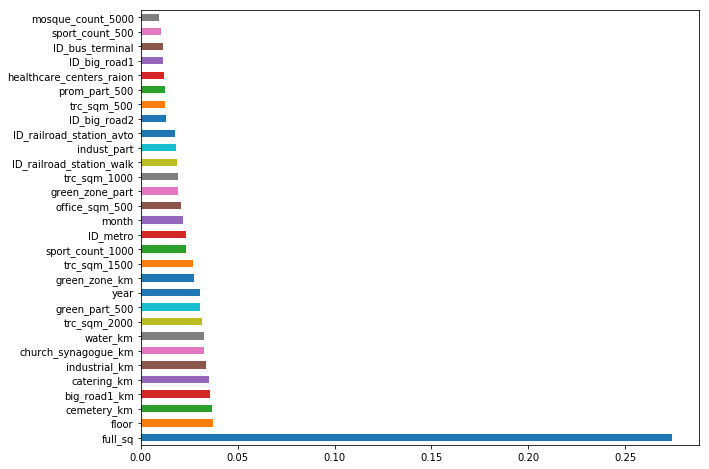

In [298]:
plt.figure(figsize=(10,8))
pd.Series(gb.feature_importances_, index=X.columns).nlargest(30).plot(kind='barh')

#### The above table gives the order of important features based on the Decision Tree. It seems sensible. For instance, any person who starts looking for a house would first ask how big it is for the price. Followed by locality and amenities which is explained by variables like metro or not, school facility, water availability,religious building availability etc...

In [299]:
importantfeatures = pd.Series(gb.feature_importances_, index=X.columns).nlargest(20).reset_index()
importantfeatures.columns = ["columnname","importance"]
#columnlist= importantfeatures["columnname"]
columnlist = list(importantfeatures["columnname"])
columnlist

['full_sq',
 'floor',
 'cemetery_km',
 'big_road1_km',
 'catering_km',
 'industrial_km',
 'church_synagogue_km',
 'water_km',
 'trc_sqm_2000',
 'green_part_500',
 'year',
 'green_zone_km',
 'trc_sqm_1500',
 'sport_count_1000',
 'ID_metro',
 'month',
 'office_sqm_500',
 'green_zone_part',
 'trc_sqm_1000',
 'ID_railroad_station_walk']

Note to self : There was a strong overlap between the variables remaining after checking for multicollinearity and the variables predicted as most important by the gradient boosted model on the original dataset. This probably means that the Decison Tree behind gradientboosting prioritizes variables that provide new information for a better split over variables that have redundant information( and hence are collinear)

# Checking Correlation

In [16]:
for i in noncollinearvar:
    print(stats.pearsonr(traindf2[i], traindf2["price_doc"]))
  #  print(stats.spearmanr(traindf1["full_sq"], traindf1["price_doc"]))

(0.34184045975381705, 0.0)
(0.11865942120265219, 5.825654447605855e-96)
(-0.09448640540244864, 2.238564683265907e-61)
(-0.08261410128650946, 2.688663875380802e-47)
(0.10228284323573879, 1.1652024817893938e-71)
(0.19000612089202654, 1.2592092403237712e-245)
(0.16582710370183157, 8.983483888157631e-187)
(0.05282403329124649, 2.7832371233543755e-20)
(-0.060750060928588374, 2.5689663992179414e-26)
(0.05273836780237563, 3.200646532578478e-20)
(-0.024943983501172606, 1.3324513695437246e-05)
(-0.021878203006099065, 0.0001338051969333813)
(-0.05129441526621732, 3.2628633999004455e-19)
(-0.026641146552873127, 3.3017166029206147e-06)
(-0.10373664250762396, 1.1413352893312573e-73)
(-0.0672344024853672, 7.127865599792633e-32)
(-0.08155916688525994, 3.879020667313589e-46)
(-0.05083285558215065, 6.76274179189308e-19)
(-0.11819683486494739, 3.178814926499752e-95)
(-0.2107932845485386, 4.155571009081269e-303)
(-0.054190722697807434, 2.905706353331597e-21)
(-0.009009216979978155, 0.11580884574595675)
(

While correlation of most columns in weak, they all seem significant as e-06 is the lowest value

# Let's visualize the relationship between all these vaiables and price

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


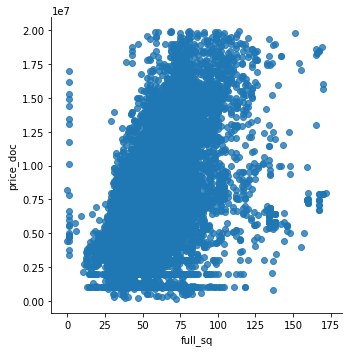

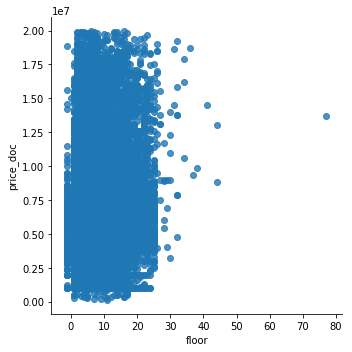

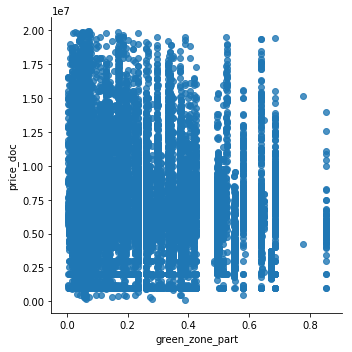

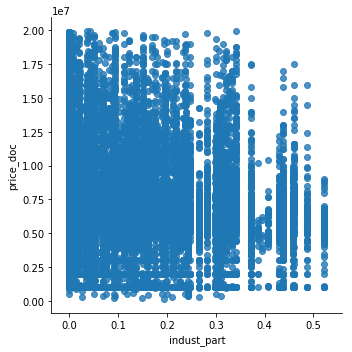

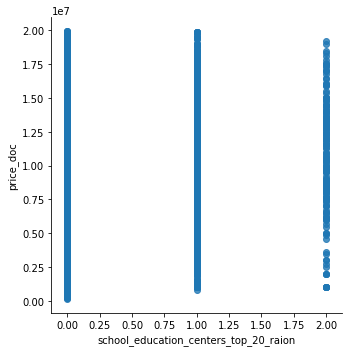

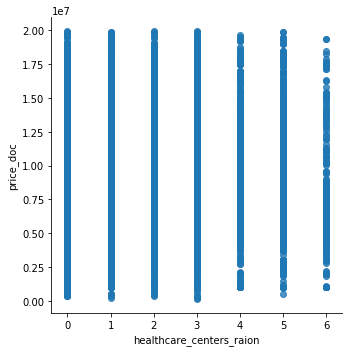

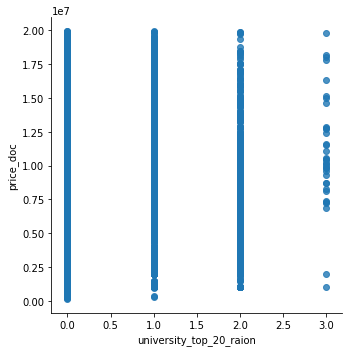

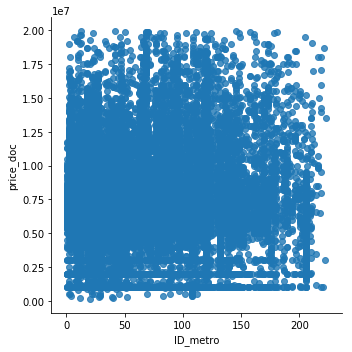

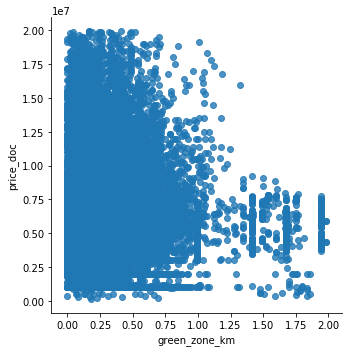

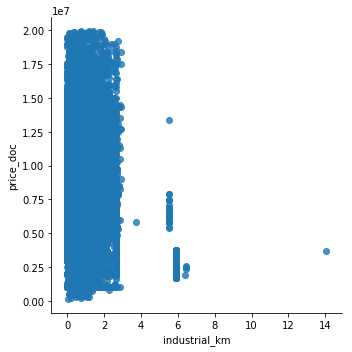

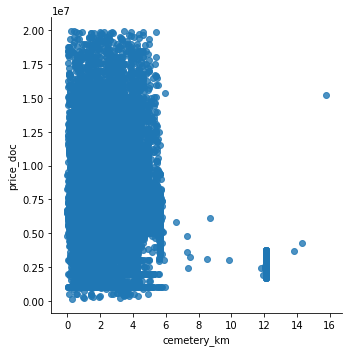

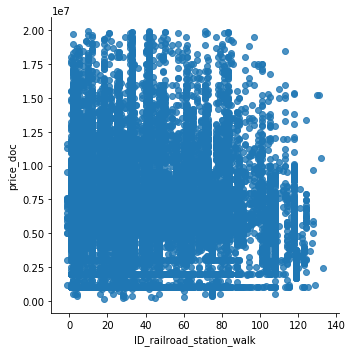

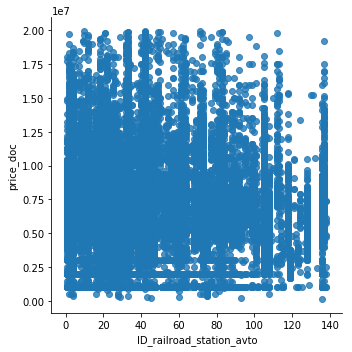

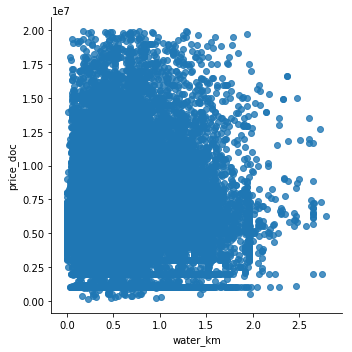

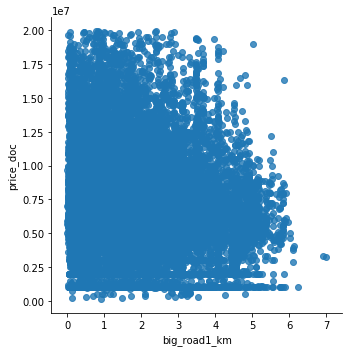

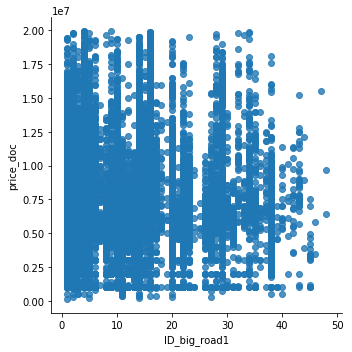

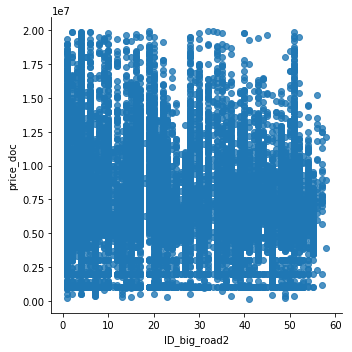

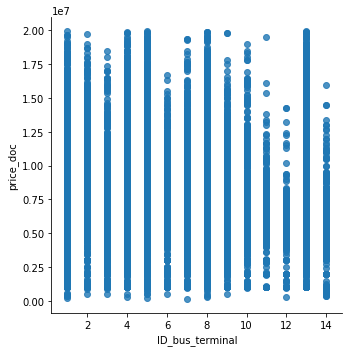

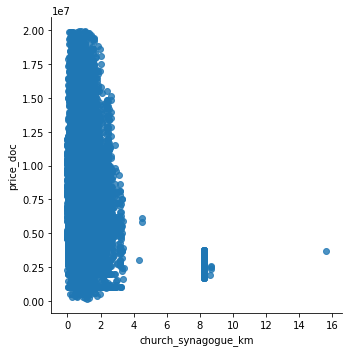

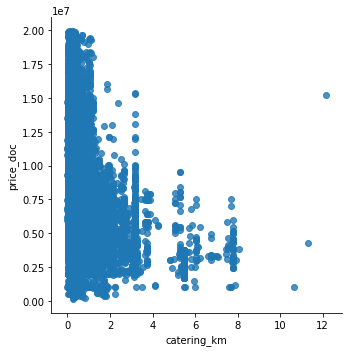

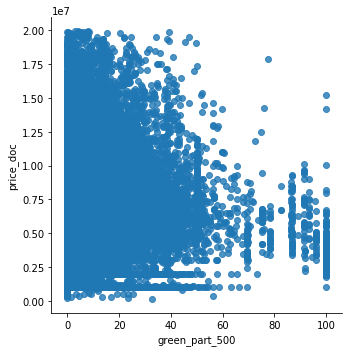

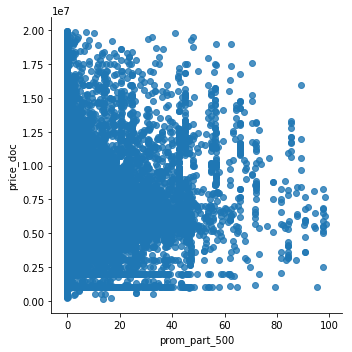

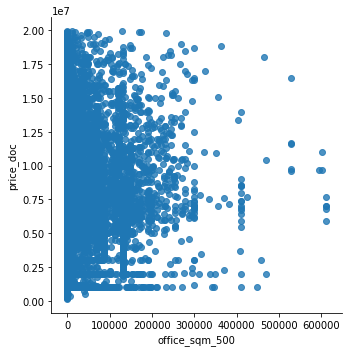

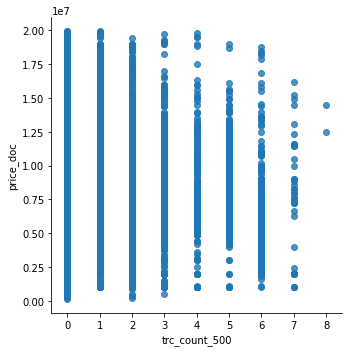

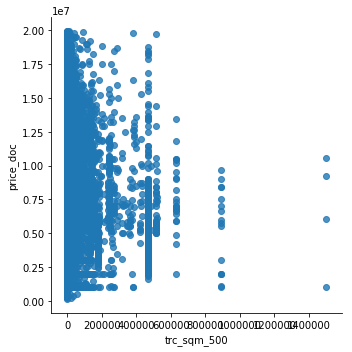

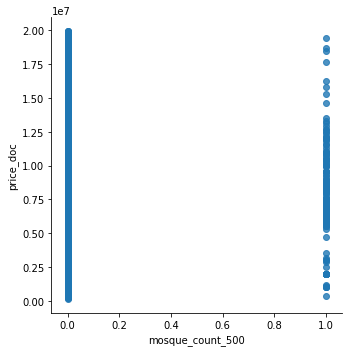

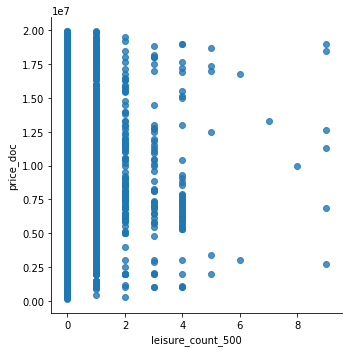

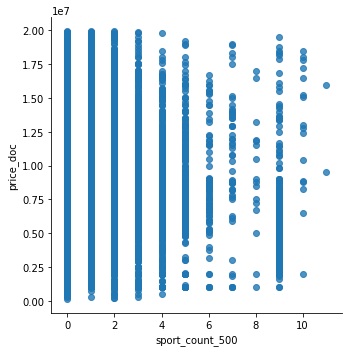

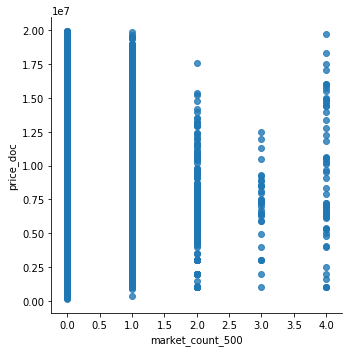

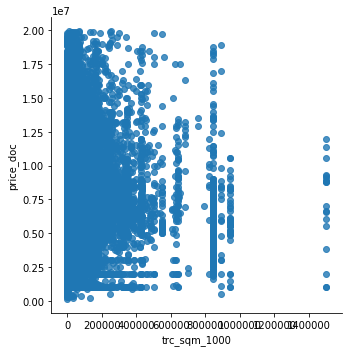

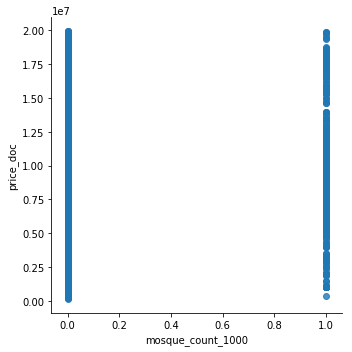

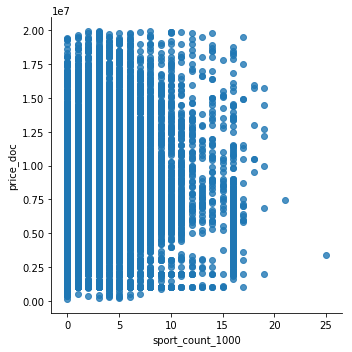

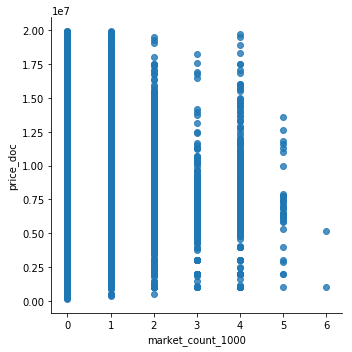

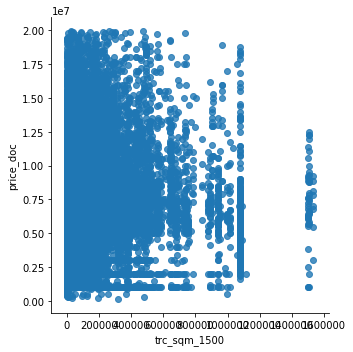

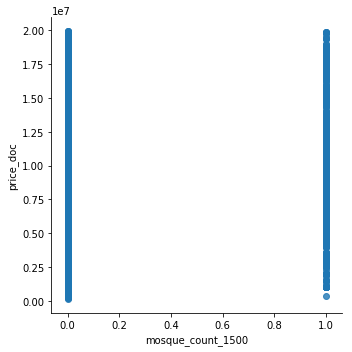

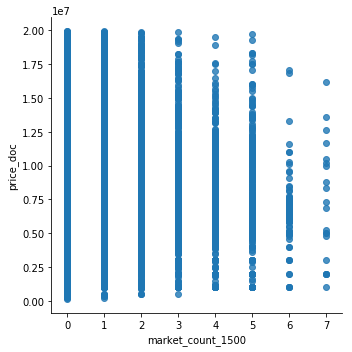

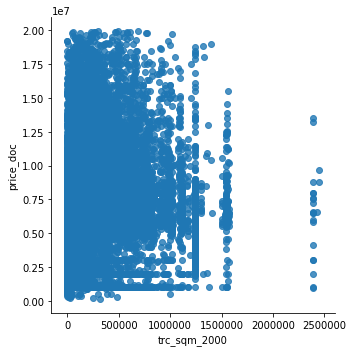

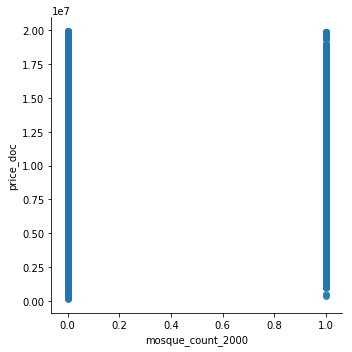

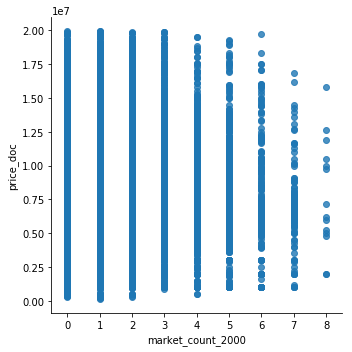

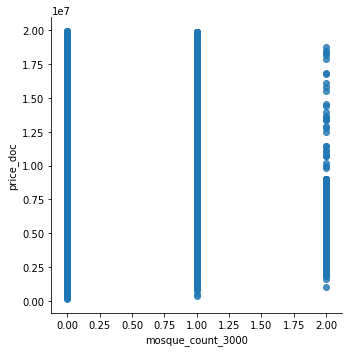

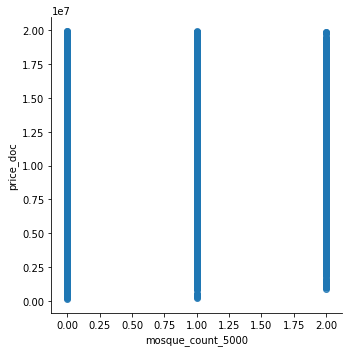

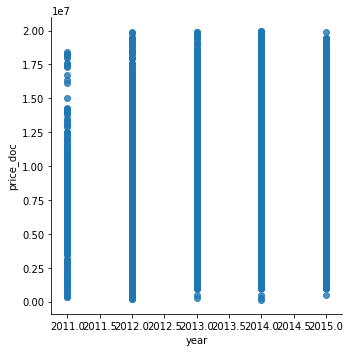

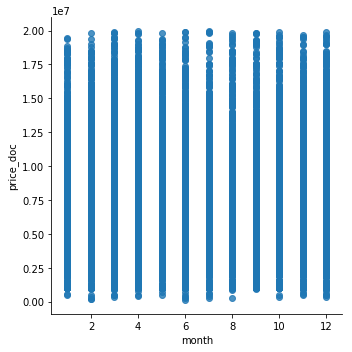

In [17]:
plotdf=traindf2[(traindf2["full_sq"]<175) & (traindf2["price_doc"]<20000000)]
for i in noncollinearvar:
    sns.lmplot(i,"price_doc",data=plotdf,fit_reg=False)

# Outlier removal on specific variables based on the above charts and prior analysis 

### 1) Removing outliers in the price_doc and full_sq variables. 2% of the data has price above 20 mil  and bring in a big variance to the data. We do not want this 2% to influnce the model scores and therefore the final results. Hence, this data is removed. 

### 2)We are also removing full_sq >175 as this seems like the most important variable and outliers in this variable again might affect final predictions.

In [20]:
traindf3 = traindf2[(traindf2["full_sq"]<175) & (traindf2["price_doc"]<20000000)]

Extracting only the variables with low VIF scores as features

In [105]:
featuredata=traindf3[noncollinearvar]
testdf3=testdf2[noncollinearvar]
Y=traindf3["price_doc"]
#featuredata.drop("water_km",axis=1,inplace=True)
featuredata.shape

(29886, 43)

# Data Sampling. Test Train split creation from the train dataset given

In [22]:
xtrain, xtest, ytrain, ytest = train_test_split(featuredata,Y, test_size=0.3,random_state=seed)
print (xtrain.shape, ytrain.shape)
print (xtest.shape, ytest.shape)

(20920, 43) (20920,)
(8966, 43) (8966,)


# Model Evaluation Metrics:
Defining metrics that the model will be evaluated on:

We are evaluating the model on three metrics:

Root mean Square Log error:

In case of price predictions, the RMSLE is used when you do not want to penalize the model for high differences. As in when the actual and the prediction values are very large, relative small differences might be amplified when taking absolute mean square. Hence Log of the values are used to not penalize large differences.



Root mean Square error:

We are also looking at the residual errors to compare models.



R2 score:

R2 can be calculated in two ways. SSR/SST or 1 - SSE/SST.Both 
these options should yield that same value, provided the regression line 
predicts better than mean. But in this case, the prediction is so bad that 
SSE is higher than SST, meaning the regression line residuals are greater than
difference between actual points and their mean.

I am assuming the r2score function uses 1- SSE/SST, and therefore the R2 is -ve.

In [55]:
def RMSLE(y, y0):
    return np.sqrt(np.mean(np.square(np.log1p(y) - np.log1p(y0))))
    
def RMSE(y, y0):
    return np.sqrt(np.mean(np.square(y- y0)))
    
def r2(y,y0):
    return r2_score(y, y0)
    

## A basline OLS model 

In [26]:
model = sm.OLS(ytrain,xtrain)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     3962.
Date:                Mon, 11 Feb 2019   Prob (F-statistic):               0.00
Time:                        11:31:15   Log-Likelihood:            -3.3760e+05
No. Observations:               20920   AIC:                         6.753e+05
Df Residuals:                   20877   BIC:                         6.756e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

# Inference:
    
    Since the variables are on different scales, the coefficients are not directly comparable to each other. But , looking at the most important variables in the model from the feature importance set, we infer  that :
    
    For 1 unit increase in full sq,the price increases by 541 units( 9.92 * e^4), all else being constant
    For 1 unit increase in floor,the price increase by 247 units( 4.50 * e^4), all else being constant
    For 1 unit increase in full sq,the price increase  by 175 units( 1.176e+05), all else being constant
    For 1 unit increase in big road,the price decreases by 235 units( -1.584e+05), all else being constant.
   
It is interesting to note that bigger the road, lower in the price of the house, which would not be your initial assumption. 

Now the reason for removing highly correlated variables and checking for multicollinearity is that, now these coefficients are reliable and will not vary much based on other variables being added, as there is no overlap of information in those variables. This helps with a clean inference

In [100]:
print(stats.pearsonr(traindf3["big_road1_km"], traindf3["price_doc"]))

(-0.10999643759461701, 4.248506135656419e-81)


Whilst not strong, there is indeed a negative correlation between the two variables

In [28]:
predictions = results.predict(xtest)
predictions.head()

21751    5.961929e+06
11944    3.913288e+06
7063     4.222120e+06
16249    6.890992e+06
12261    1.031254e+07
dtype: float64

In [56]:
LR_RMSLE = RMSLE(ytest,predictions)
LR_RMSE = RMSE(ytest,predictions)
LR_R2 = r2(ytest,predictions)

print("RMSLE :",LR_RMSLE,"\nRMSE:",LR_RMSE,"\nR2:",LR_R2)

RMSLE : 0.5160817908635075 
RMSE: 2499562.618524739 
R2: 0.42311344497864145


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


Trying out ridge regression and Lasso regression here to reduce effect of coefficients of any one predictor to better generalize the model and not have it leaning on a single predictor

# Ridge Regression

In [57]:
ridgereg = Ridge(alpha=.1,normalize=True, max_iter=200)
ridgereg.fit(xtrain,ytrain)
ridgereg_pred = ridgereg.predict(xtest)

In [58]:
RR_RMSLE = RMSLE(ytest,ridgereg_pred)
RR_RMSE = RMSE(ytest,ridgereg_pred)
RR_R2 = r2(ytest,ridgereg_pred)

print("RMSLE :",RR_RMSLE,"\nRMSE:",RR_RMSE,"\nR2:",RR_R2)

RMSLE : 0.5030647749459621 
RMSE: 2461009.454733221 
R2: 0.44077195932674595


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


# Lasso Regression

In [59]:
lassoreg = Lasso(alpha=.1,normalize=True, max_iter=200)
lassoreg.fit(xtrain,ytrain)
lassoreg_pred = lassoreg.predict(xtest)

In [60]:
LAR_RMSLE = RMSLE(ytest,lassoreg_pred)
LAR_RMSE = RMSE(ytest,lassoreg_pred)
LAR_R2 = r2(ytest,lassoreg_pred)

print("RMSLE :",LAR_RMSLE,"\nRMSE:",LAR_RMSE,"\nR2:",LAR_R2)

RMSLE : 0.5049889617999765 
RMSE: 2457491.0193233127 
R2: 0.4423698412204943


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


Most variables don't seem to have a linear relationship with price_doc. We
either have to transform them to check for linearity or use a non paramteric method. Let's try decision trees as they do not make assumptions about the distribution of the data.

# Random Forest

In [89]:
param_grid = [{"max_depth":[5,8,10], "max_features":["sqrt","log2","auto"]}]
grid = GridSearchCV(RandomForestRegressor(),param_grid, cv=3, n_jobs =-1)
grid.fit(xtrain,ytrain)
rf = grid.best_estimator_
rf.fit(xtrain,ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [90]:
print("The Best hyperparamters of the model are",grid.best_params_)

The Best hyperparamters of the model are {'max_depth': 10, 'max_features': 'auto'}


In [61]:
rf_pred = rf.predict(xtest)
rf_RMSLE = RMSLE(ytest,rf_pred)
rf_RMSE = RMSE(ytest,rf_pred)
rf_R2 = r2(ytest,rf_pred)

print("RMSLE :",rf_RMSLE,"\nRMSE:",rf_RMSE,"\nR2:",rf_R2)

RMSLE : 0.4771582645378762 
RMSE: 2227195.5965373125 
R2: 0.5419856408281105


### Feature Importance chart for Random Forest

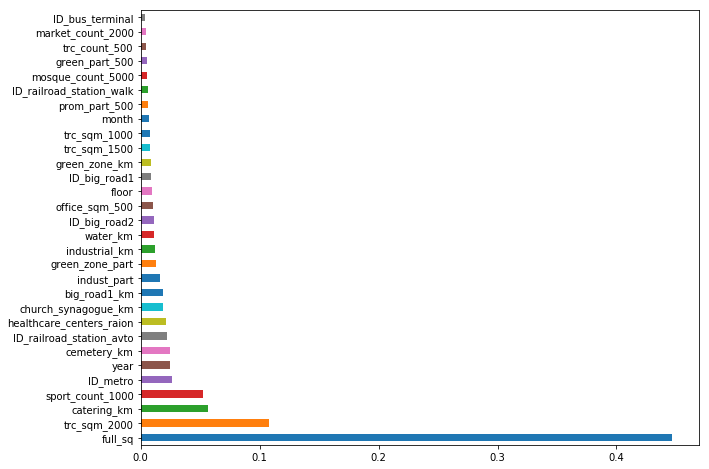

In [62]:
plt.figure(figsize=(10,8))
pd.Series(rf.feature_importances_, index=xtrain.columns).nlargest(30).plot(kind='barh')

# Gradient Boosting

Using Grid Search to tune hyperparameters of the model

In [94]:
param_grid = [{"max_depth":[5,8,10], "max_features":["sqrt","log2","auto"],"n_estimators":[100,200,300]}]
grid = GridSearchCV(GradientBoostingRegressor(),param_grid, cv=3, n_jobs =-1)
grid.fit(xtrain,ytrain)
gb = grid.best_estimator_
gb.fit(xtrain,ytrain)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5,
             max_features='log2', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=300,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [87]:
print("The Best hyperparamters of the model are",grid.best_params_)

The Best hyperparamters of the model are {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 300}


In [95]:
gb_pred = gb.predict(xtest)
gb_RMSLE = RMSLE(ytest,gb_pred)
gb_RMSE = RMSE(ytest,gb_pred)
gb_R2 = r2(ytest,gb_pred)

print("RMSLE :",gb_RMSLE,"\nRMSE:",gb_RMSE,"\nR2:",gb_R2)
#testgb_pred = gb.predict(testdf3)

RMSLE : 0.47042249878086567 
RMSE: 2148783.494662678 
R2: 0.573668233140054


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


### Feature importance chart for GB

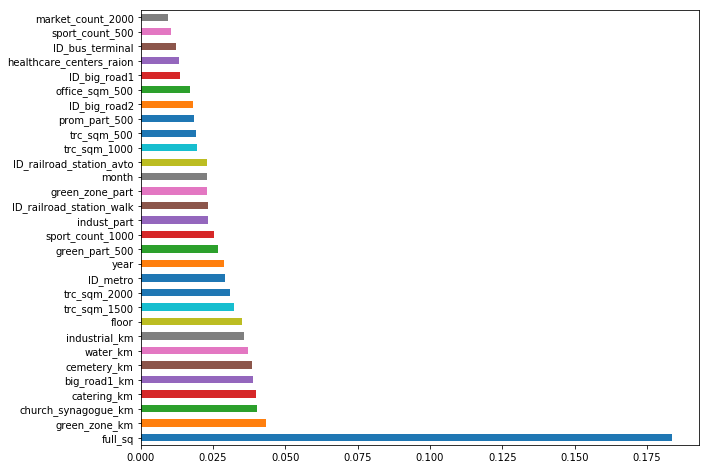

In [63]:
plt.figure(figsize=(10,8))
pd.Series(gb.feature_importances_, index=xtrain.columns).nlargest(30).plot(kind='barh')

# Model Comparison based on the evaluation metrics

In [96]:
model_compare=[{"Name":'Linear Reg',"RMSLE":LR_RMSLE,"RMSE":LR_RMSE,"R2":LR_R2},
               {"Name":'Ridge Reg',"RMSLE":RR_RMSLE,"RMSE":RR_RMSE,"R2":RR_R2},
               {"Name":'Lasso Reg',"RMSLE":LAR_RMSLE,"RMSE":LAR_RMSE,"R2":LAR_R2},
               {"Name":'Random Forest',"RMSLE":rf_RMSLE,"RMSE":rf_RMSE,"R2":rf_R2},
               {"Name":'Gradient Boosting',"RMSLE":gb_RMSLE,"RMSE":gb_RMSE,"R2":gb_R2}]

model_comparedf = pd.DataFrame(model_compare)
model_comparedf =model_comparedf.set_index('Name')
print(model_comparedf)

                         R2          RMSE     RMSLE
Name                                               
Linear Reg         0.423113  2.499563e+06  0.516082
Ridge Reg          0.440772  2.461009e+06  0.503065
Lasso Reg          0.442370  2.457491e+06  0.504989
Random Forest      0.541986  2.227196e+06  0.477158
Gradient Boosting  0.573668  2.148783e+06  0.470422


## R2 Score Comparison

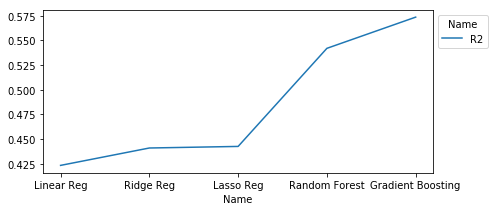

In [102]:
model_comparedf[["R2"]].plot(figsize=(7,3), xticks=range(0, 5)).legend(title='Name', bbox_to_anchor=(1, 1))

## RMSLE Comparison

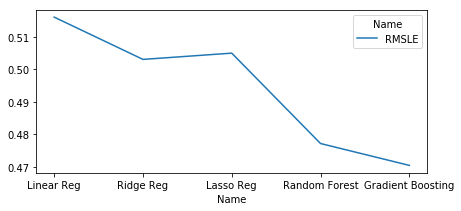

In [103]:
model_comparedf[["RMSLE"]].plot(figsize=(7,3), xticks=range(0, 5)).legend(title='Name', bbox_to_anchor=(1, 1))

## RMSE Comparison

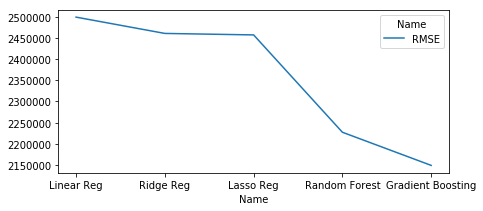

In [104]:
model_comparedf[["RMSE"]].plot(figsize=(7,3), xticks=range(0, 5)).legend(title='Name', bbox_to_anchor=(1, 1))

### Clearly, the Gradient Boosting Model has the highest R2 score and the lowest RMSE and RMSLE scores of all the models and outperforms all other models. Hence, the final prediction would be the ones coming out of the Gradient Boosted Model.